In [1]:
%load_ext autoreload
%autoreload 2

# Example of a pvsystemprofiler function


## 8/10/2021

### Notebook setup and library imports

In [2]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# PVInsight Code Imports
from solardatatools import DataHandler
from solardatatools.dataio import get_pvdaq_data
sys.path.append('..')
sys.path.append('~/github/pv-system-profiler')
from pvsystemprofiler.estimator import ConfigurationEstimator
from pvsystemprofiler.longitude_study import LongitudeStudy

### Load data table from external source

For today's example, we're loading data from NREL's PVDAQ API, which is a publically available PV generatation data set. 

In [3]:
data_frame = get_pvdaq_data(sysid=1199, year=[2015, 2016, 2017], api_key='DEMO_KEY')

CAUTION: Multiple scan rates detected!=======================] 100.0% ...queries complete in 25.0 seconds       
Scan rates (in seconds): [300, 280]
0 transitions detected.
Suggest splitting data set between:




### Running the `DataHandler` processing pipeline

In [4]:
dh = DataHandler(data_frame)

In [5]:
dh.run_pipeline(power_col='ac_power', fix_shifts=False, correct_tz=True)

total time: 13.56 seconds
--------------------------------
Breakdown
--------------------------------
Preprocessing              10.75s
Cleaning                   0.52s
Filtering/Summarizing      2.30s
    Data quality           0.41s
    Clear day detect       0.30s
    Clipping detect        0.31s
    Capacity change detect 1.28s



In [6]:
#dh.run_pipeline(power_col='ac_power', fix_shifts=False, correct_tz=False)

### Site longitude and latitude downloaded from https://maps.nrel.gov/pvdaq/ PVDAQ Contributed Sites

In [7]:
latitude = 39.4856
longitude = -76.6636
tilt = 180
azimuth = 20
gmt_offset = -5

### Import sunrise_sunset method to calculate the daily solar noon

In [8]:
from pvsystemprofiler.algorithms.optimized_sunrise_sunset import get_optimized_sunrise_sunset

### Prepare input values to estimate the daily sunrise and sunset hour

### For this function, one of the input values is set to None at one time. It gives the option to calculate sunrise and sunset hours using either the raw data matrix (rdm) or the filled data matrix (fdm)

In [9]:
#fdm = None
#rdm = dh.raw_data_matrix
fdm = dh.filled_data_matrix
rdm = None

In [10]:
day_of_year = dh.day_index.dayofyear

In [11]:
days = dh.daily_flags.no_errors

### The method opt_dict returns a dictionary with the daily sunrise and sunset hours and the threshold value

In [12]:
# opt_dict = get_optimized_sunrise_sunset(fdm, rdm)

In [13]:
# opt_dict

### Estimate solar noon using estimated values in the dictionary

In [14]:
# sunrise = opt_dict['meas_sr_f']
# sunset = opt_dict['meas_ss_f']
# sunrise[np.isnan(sunrise)] = 0
# sunset[np.isnan(sunset)] = 0

In [15]:
# solarnoon = np.nanmean([sunrise, sunset], axis=0)

In [16]:
from solardatatools.solar_noon import avg_sunrise_sunset

In [17]:
solarnoon = avg_sunrise_sunset(dh.raw_data_matrix)
solarnoon

array([11.20833333, 11.20833333, 10.83333333, ..., 11.20833333,
       11.70833333, 11.29166667])

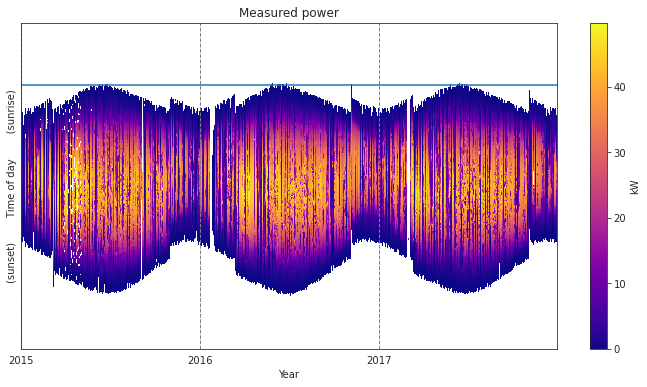

In [18]:
dh.plot_heatmap(matrix='raw')
plt.axhline(y=55)

In [19]:
from pvsystemprofiler.utilities.equation_of_time import eot_da_rosa, eot_duffie

### Equation of time prosposed by Duffie

In [20]:
eot_duffie = eot_duffie(day_of_year)

### Equation of time prosposed by da Rosa

In [21]:
eot_da_rosa = eot_da_rosa(day_of_year)

### Fit longitude using previously estimated solarnoon

In [22]:
from pvsystemprofiler.algorithms.longitude.fitting import fit_longitude

In [23]:
fit_longitude(eot_duffie, solarnoon, days, gmt_offset, loss='l2')

-72.55225056392015

### Fit longitude using parameters internal to the LongitudeStudy class

In [24]:
lon_study = LongitudeStudy(data_handler=dh, gmt_offset=gmt_offset, true_value=longitude)

In [25]:
lon_study.run(verbose=False, data_matrix='filled', estimator='fit_l2', day_selection_method='all',
              eot_calculation='duffie', solar_noon_method='optimized_measurements')

### use solarnoon calculated internally

In [26]:
solarnoon2 = lon_study.solarnoon

### Use days calculated internally

In [27]:
day_of_year2 = lon_study.data_handler.day_index.dayofyear

### Use internal eout Duffie

In [28]:
eot_duffie2 = lon_study.eot_duffie

In [29]:
days2 = lon_study.days

In [30]:
fit_longitude(eot_duffie2, solarnoon2, days2, gmt_offset, loss='l2')

-72.30153423154192

In [31]:
solarnoon

array([11.20833333, 11.20833333, 10.83333333, ..., 11.20833333,
       11.70833333, 11.29166667])